This notebook shows how to build a simple environment that models a warehouse with rows of shelves. The robot, denoted by an 'X' when rendering, has to go to the bottom right.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
class GridWorld(object):
    def __init__(self):
        self.m = 9
        self.n = 9
        self.grid = np.zeros((self.m, self.n))
        self.grid[1:-1,1:8:2] = 2 # '2' is just a marker for shelf grids, see render()
        self.stateSpace = [i for i in range(self.m*self.n)]
        self.stateSpace.remove(80)
        self.stateSpacePlus = [i for i in range(self.m*self.n)]
        self.actionSpace = {'U': -self.m, 'D': self.m,
                            'L': -1, 'R': 1}
        self.possibleActions = ['U', 'D', 'L', 'R']
        self.agentPosition = 0
        self.grid[0][0] = 1

    def isTerminalState(self, state):
        return state in self.stateSpacePlus and state not in self.stateSpace

    def getAgentRowAndColumn(self):
        x = self.agentPosition // self.m
        y = self.agentPosition % self.n
        return x, y

    def setState(self, state):
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 0
        self.agentPosition = state
        x, y = self.getAgentRowAndColumn()
        self.grid[x][y] = 1

    def offGridMove(self, newState, oldState):
        # if we move into a row not in the grid
        if newState not in self.stateSpacePlus:
            return True
        # if we're trying to wrap around to next row
        elif oldState % self.m == 0 and newState  % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m - 1 and newState % self.m == 0:
            return True
        # if agent is crashing into shelves
        elif self.grid[newState // self.m][newState % self.n] == 6:
            return True # Alternatively, penalise moves that lead into shelves
        else:
            return False

    def step(self, action):
        agentX, agentY = self.getAgentRowAndColumn()
        resultingState = self.agentPosition + self.actionSpace[action]
        reward = -1 if not self.isTerminalState(resultingState) else 0
        if not self.offGridMove(resultingState, self.agentPosition):
            self.setState(resultingState)
            return resultingState, reward, \
                   self.isTerminalState(resultingState), None
        else:
            return self.agentPosition, reward, \
                   self.isTerminalState(self.agentPosition), None

    def reset(self):
        self.agentPosition = 0
        self.grid = np.zeros((self.m,self.n))
        self.grid[0][0] = 1
        self.grid[1:-1,1:8:2] = 2
        return self.agentPosition

    def render(self):
      x, y = self.getAgentRowAndColumn()
      print('-----------------------------------------------------------------')
      for row in self.grid:
          for col in row:
              if col == 0:
                  print('-', end='\t')
              elif col == 1:
                  print('X', end='\t')
              elif col == 2:
                  print('S', end='\t')
          print('\n')
      print('-----------------------------------------------------------------')

    def actionSpaceSample(self):
        return np.random.choice(self.possibleActions)

def maxAction(Q, state, actions):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return actions[action]

Training an agent with the custom environment built

starting game  0
starting game  2000
starting game  4000
starting game  6000
starting game  8000


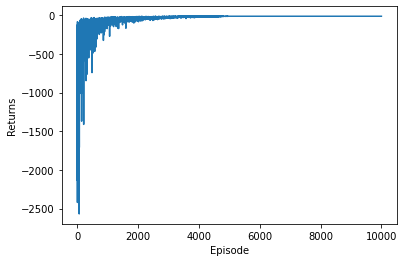

In [133]:
env = GridWorld()
# model hyperparameters
ALPHA = 0.1
GAMMA = 1.0
EPS = 1.0

Q = {}
for state in env.stateSpacePlus:
    for action in env.possibleActions:
        Q[state, action] = 0

numGames = 10000
totalREwards = np.zeros(numGames)
for i in range(numGames):
    if i % 2000 == 0:
        print('starting game ', i)
    done = False
    epRewards = 0
    observation = env.reset()
    while not done:
        rand = np.random.random()
        action = maxAction(Q,observation, env.possibleActions) if rand < (1-EPS) \
                                                else env.actionSpaceSample()
        observation_, reward, done, info = env.step(action)
        epRewards += reward

        action_ = maxAction(Q, observation_, env.possibleActions)
        Q[observation,action] = Q[observation,action] + ALPHA*(reward + \
                    GAMMA*Q[observation_,action_] - Q[observation,action])
        observation = observation_
    if EPS - 2 / numGames > 0:
        EPS -= 2 / numGames
    else:
        EPS = 0
    totalREwards[i] = epRewards

plt.plot(totalREwards)
plt.ylabel('Returns')
plt.xlabel('Episode')
plt.show()

Visualising an episode with the trained agent

In [134]:
env.reset()
env.setState(20)
env.render()

-----------------------------------------------------------------
-	-	-	-	-	-	-	-	-	

-	S	-	S	-	S	-	S	-	

-	S	X	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	-	-	-	-	-	-	-	-	

-----------------------------------------------------------------


In [135]:
from IPython.display import clear_output
from time import sleep

In [136]:
done = False
observation = 20
while not done:
    action = maxAction(Q,observation, env.possibleActions)
    observation, reward, done, info = env.step(action)
    clear_output(wait=True)
    env.render()
    sleep(.3)

-----------------------------------------------------------------
-	-	-	-	-	-	-	-	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	S	-	S	-	S	-	S	-	

-	-	-	-	-	-	-	-	X	

-----------------------------------------------------------------
